# 第五章 大语言模型评估以及用 W&B 追踪 Evaluation and Tracing  

我们会探究三个例子：  
一、联合使用大语言模型 API 和 wandb 表格  
二、用追踪器 (Tracer) 追踪大语言模型链  
三、追踪 Langchain 代理 (agent)

<div class="toc">
    <ul class="toc-item">
        <li><span><a href="#一使用表格进行评估" data-toc-modified-id="一、使用表格进行评估">一、使用表格进行评估</a></span></li>
        <li><span><a href="#二使用追踪器来记录更复杂的链" data-toc-modified-id="二、使用追踪器来记录更复杂的链">二、使用追踪器来记录更复杂的链</a></span></li>
        <li><span><a href="#三Langchain 代理" data-toc-modified-id="三、Langchain 代理">三、Langchain 代理</a></span></li>
    </ul>
</div>

## 一、使用表格进行评估  

本节中，我们会调用 OpenAI 的大语言模型来生成我们游戏资产的名字。我们会使用 W&B 表格来进行评估。

在这种情况下，我们将遵循一个简单的工作流程。首先，我们会设计系统和用户 Prompt。之后调用 OpenAI 的 API。随着 API 响应，我们会解析结果，并用 wandb 表格进行记录。

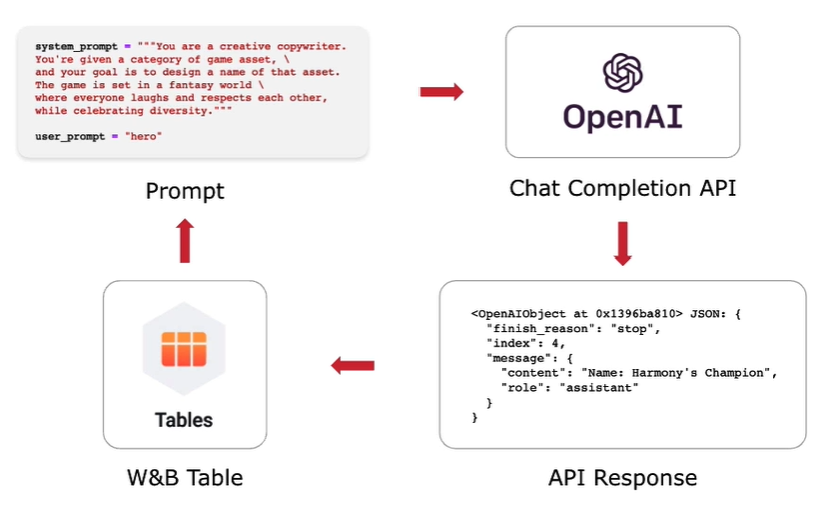

In [1]:
# 导入相应的库
import os
import random
import time
import datetime

import openai

from tenacity import (
    retry,
    stop_after_attempt,
    wait_random_exponential, # 为指数回退 (for exponential backoff)
)  
import wandb
from wandb.sdk.data_types.trace_tree import Trace

In [2]:
# 获取 OpenAI 的 API
import openai

# 您的OpenAI-API
openai.api_key = 'sk-XXX'

In [3]:
# 定义相应变量
PROJECT = "dlai_llm"
MODEL_NAME = "gpt-3.5-turbo"

In [4]:
# 登陆wandb
wandb.login(anonymous="allow")

wandb: Currently logged in as: 1450620249 (random-walk). Use `wandb login --relogin` to force relogin


True

In [5]:
# 初始化
run = wandb.init(project=PROJECT, job_type="generation")

### 简单的生成

使用 OpenAI 的 `ChatCompletion` 来为游戏资产 (game assets) 生成名字，然乎在 W&B 表格中保存生成。

In [6]:
@retry(wait=wait_random_exponential(min=1, max=60), stop=stop_after_attempt(6))
def completion_with_backoff(**kwargs):
    "这个函数能避免速率限制 (rate limits)"
    
    return openai.ChatCompletion.create(**kwargs)

这里我们定义一个函数，包含系统和用户 Prompt 和 W&B 表格。我们会使用 `completion_with_backoff` 函数来收集回答。另外，我们也会在每次回答后追踪开始时间和结束时间。对于每个生成的回答，我们会打印出结果。如果我们运行了很多实验，那么打印出的结果就不是很有效。而这也是我们为什么要将所有输出记录到一个表里面。

In [7]:
def generate_and_print(system_prompt, user_prompt, table, n=5):
    messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ]
    start_time = time.time()
    responses = completion_with_backoff(
        model=MODEL_NAME,
        messages=messages,
        n = n,
        )
    elapsed_time = time.time() - start_time
    for response in responses.choices:
        generation = response.message.content
        print(generation)
    table.add_data(system_prompt,
                user_prompt,
                [response.message.content for response in responses.choices],
                elapsed_time,
                datetime.datetime.fromtimestamp(responses.created),
                responses.model,
                responses.usage.prompt_tokens,
                responses.usage.completion_tokens,
                responses.usage.total_tokens
                )

接下来，我们定义了系统 Prompt，它要语言模型变成一个有创造力的撰稿人，能根据类别为游戏资产生成名称。

In [8]:
system_prompt = """You are a creative copywriter.
You're given a category of game asset, \
and your goal is to design a name of that asset.
The game is set in a fantasy world \
where everyone laughs and respects each other, 
while celebrating diversity."""

In [9]:
system_prompt_cn = """你是一个有创意的撰稿人。 \
根据给定的游戏资产类别， \
你的目标是为该资产设计一个名称。 \
游戏设定在一个幻想的世界里，每个人都很快乐且互相尊重，同时庆祝多样性。"""

In [10]:
# 定义包含要追踪的列名的 W&B 表格
columns = ["system_prompt", "user_prompt", "generations", "elapsed_time", "timestamp",\
            "model", "prompt_tokens", "completion_tokens", "total_tokens"]
table = wandb.Table(columns=columns)

然后，我们让用户 Prompt 从 hero 开始，看看模型能生成什么

In [11]:
user_prompt = "hero"
generate_and_print(system_prompt, user_prompt, table)

Unity's Valor
Unity Uniter
Jovial Champions
Rainbow Champion
Laughing Legends


In [12]:
user_prompt_cn = "英雄"
generate_and_print(system_prompt_cn, user_prompt_cn, table)

幸福之翼
守护之星
尊世者
星光勇者
太阳之道


接着，我们让用户 Prompt 为 jewel，看看模型能生成什么

In [13]:
user_prompt = "jewel"
generate_and_print(system_prompt, user_prompt, table)

Harmony Gems
Harmony Gems
Diversity Delights
GleamMosaic
Harmony Gems


In [14]:
user_prompt_cn = "珠宝"
generate_and_print(system_prompt_cn, user_prompt_cn, table)

宝石花园
瑰丽宝珠
幻梦璀璨
幻影之宝
幻彩宝典


现在，我们记录这个表然后到 wandb 里面看看

In [15]:
wandb.log({"simple_generations": table})
run.finish()

打开上述结果第二行的网址，并加上1列成本/cost (token数量*0.0000015)

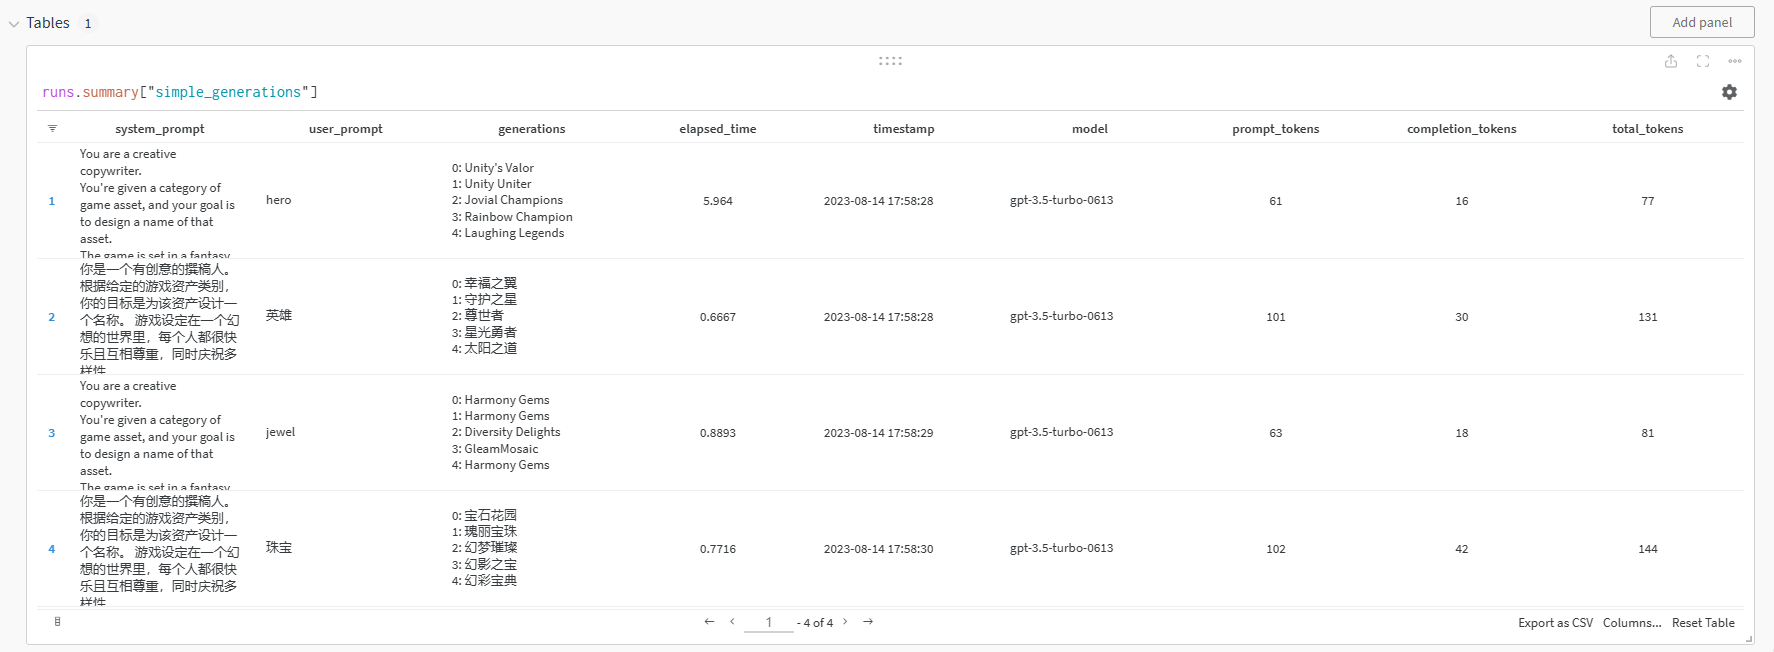

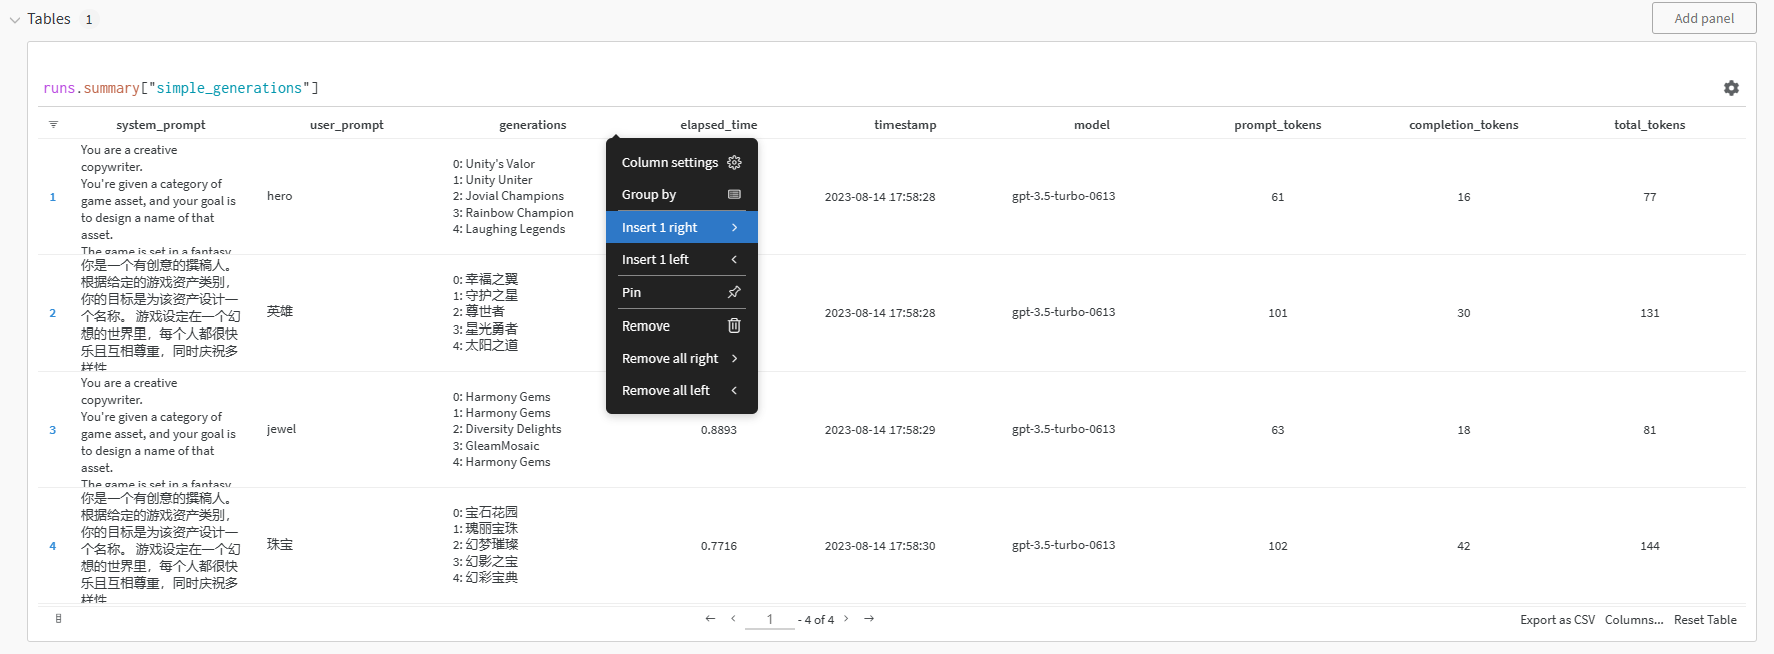

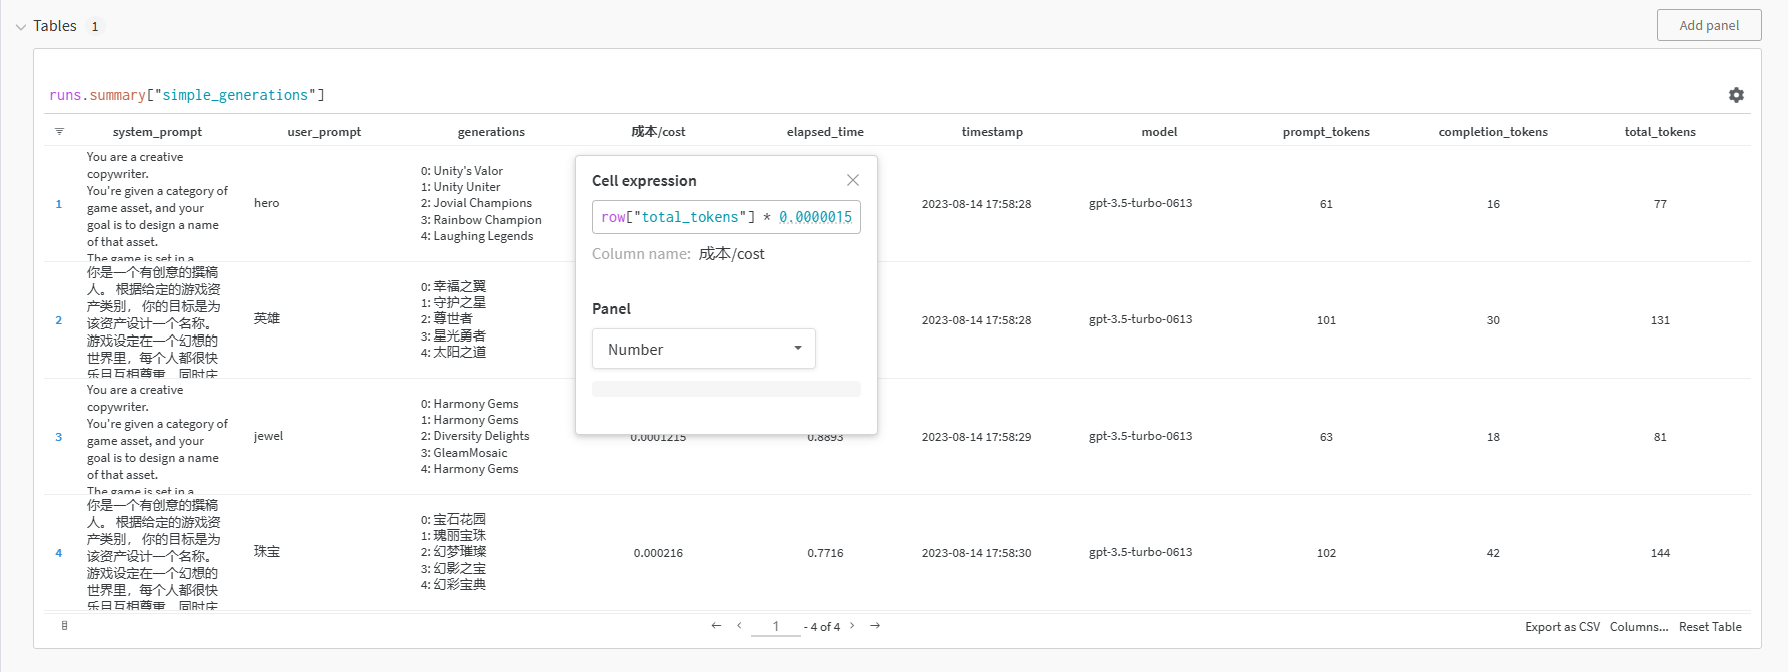

## 二、使用追踪器来记录更复杂的链

我们如何获取更有创意的输出？让我们设计一个大语言链，它首先将随机选择一个虚幻世界，然后生成角色名字。我们将演示如何在这样的场景里使用追踪器 (Tracer)。我们将记录输入与输出、开始和结束时间、OpenAI 调用是否成功、token 使用量和额外的元数据。

我们的链会包括两部分。第一步是选择一个虚拟世界，我们将称之为 World Picker。当我们使用这个工具时，我们将跟踪各个方面，例如输入、输出、开始和结束时间、结果，以及操作是否成功。然后将输出(即虚拟世界)传递给链中的下一步，该步骤会生成描述。此步骤有另一组输出和输入，以及它们在最终结果中的开始和结束时间让我们跟踪。这两个步骤都将作为跨度 (span) 进行跟踪。它们将成为 MyChain Trace 的一部分，这将使我们能够理解和分析此工作流程。

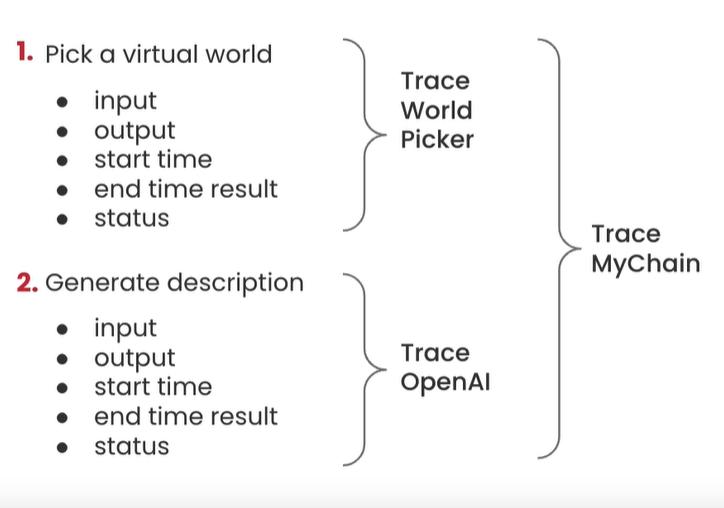

我们先生成三个 worlds，并随机选择

In [16]:
worlds = [
    "a mystic medieval island inhabited by intelligent and funny frogs",
    "a modern castle sitting on top of a volcano in a faraway galaxy",
    "a digital world inhabited by friendly machine learning engineers"
]

In [17]:
worlds_cn = [
    "一个神秘的中世纪岛屿，居住着聪明有趣的青蛙",
    "一座坐落在遥远星系火山顶上的现代城堡",
    "一个由友好的机器学习工程师居住的数字世界"
]

In [18]:
# 定义配置
model_name = "gpt-3.5-turbo"
temperature = 0.7
system_message = """You are a creative copywriter. 
You're given a category of game asset and a fantasy world.
Your goal is to design a name of that asset.
Provide the resulting name only, no additional description.
Single name, max 3 words output, remember!"""
system_message_cn = """你是一个有创意的撰稿人。给你一个游戏资产类别和一个幻想世界。您的目标是为该资产设计一个名称。只提供结果名称，不提供其他描述。单一名称，最多3个字输出，记住!"""

In [19]:
def run_creative_chain(query):
    # 部分1 - 链开始了
    start_time_ms = round(datetime.datetime.now().timestamp() * 1000)

    # 我们会从顶层的 root span 开始
    root_span = Trace(
          name="MyCreativeChain",
          kind="chain",
          start_time_ms=start_time_ms,
          metadata={"user": "student_1"},
          model_dict={"_kind": "CreativeChain"}
          )

    # 部分2 - 链随机选择一个虚幻世界
    time.sleep(3)
    world = random.choice(worlds)
    expanded_prompt = f'Game asset category: {query}; fantasy world description: {world}'
    tool_end_time_ms = round(datetime.datetime.now().timestamp() * 1000)

    # 创建一个tool span
    tool_span = Trace(
          name="WorldPicker",
          kind="tool",
          status_code="success",
          start_time_ms=start_time_ms,
          end_time_ms=tool_end_time_ms,
          inputs={"input": query},
          outputs={"result": expanded_prompt},
          model_dict={"_kind": "tool", "num_worlds": len(worlds)}
          )

    # 将上面的 tool span 添加为 root span 的子
    root_span.add_child(tool_span)

    # 部分3 - 将工具 span 的输出传递至大语言模型链
    messages=[
      {"role": "system", "content": system_message},
      {"role": "user", "content": expanded_prompt}
    ]

    response = completion_with_backoff(model=model_name,
                                       messages=messages,
                                       max_tokens=12,
                                       temperature=temperature)   

    llm_end_time_ms = round(datetime.datetime.now().timestamp() * 1000)
    response_text = response["choices"][0]["message"]["content"]
    token_usage = response["usage"].to_dict()

    llm_span = Trace(
          name="OpenAI",
          kind="llm",
          status_code="success",
          metadata={"temperature":temperature,
                    "token_usage": token_usage, 
                    "model_name":model_name},
          start_time_ms=tool_end_time_ms,
          end_time_ms=llm_end_time_ms,
          inputs={"system_prompt":system_message, "query":expanded_prompt},
          outputs={"response": response_text},
          model_dict={"_kind": "Openai", "engine": response["model"], "model": response["object"]}
          )

    # 将大模型 span 添加为链 span的子
    root_span.add_child(llm_span)

    # 更新链 span 的输入和输出
    root_span.add_inputs_and_outputs(
          inputs={"query":query},
          outputs={"response": response_text})

    # u更新链 span 的结束时间
    root_span.end_time_ms = llm_end_time_ms


    # 部分4 - 通过记录 root span 来记录所有 spans 到 W&B 表
    root_span.log(name="creative_trace")
    print(f"Result: {response_text}")


In [20]:
def run_creative_chain_cn(query):
    # 部分1 - 链开始了
    start_time_ms = round(datetime.datetime.now().timestamp() * 1000)

    # 我们会从顶层的 root span 开始
    root_span = Trace(
          name="MyCreativeChain",
          kind="chain",
          start_time_ms=start_time_ms,
          metadata={"user": "student_1"},
          model_dict={"_kind": "CreativeChain"}
          )

    # 部分2 - 链随机选择一个虚幻世界
    time.sleep(3)
    world = random.choice(worlds_cn)
    expanded_prompt = f'Game asset category: {query}; fantasy world description: {world}'
    tool_end_time_ms = round(datetime.datetime.now().timestamp() * 1000)

    # 创建一个tool span
    tool_span = Trace(
          name="WorldPicker",
          kind="tool",
          status_code="success",
          start_time_ms=start_time_ms,
          end_time_ms=tool_end_time_ms,
          inputs={"input": query},
          outputs={"result": expanded_prompt},
          model_dict={"_kind": "tool", "num_worlds": len(worlds)}
          )

    # 将上面的 tool span 添加为 root span 的子
    root_span.add_child(tool_span)

    # 部分3 - 将工具 span 的输出传递至大语言模型链
    messages=[
      {"role": "system", "content": system_message_cn},
      {"role": "user", "content": expanded_prompt}
    ]

    response = completion_with_backoff(model=model_name,
                                       messages=messages,
                                       max_tokens=12,
                                       temperature=temperature)   

    llm_end_time_ms = round(datetime.datetime.now().timestamp() * 1000)
    response_text = response["choices"][0]["message"]["content"]
    token_usage = response["usage"].to_dict()

    llm_span = Trace(
          name="OpenAI",
          kind="llm",
          status_code="success",
          metadata={"temperature":temperature,
                    "token_usage": token_usage, 
                    "model_name":model_name},
          start_time_ms=tool_end_time_ms,
          end_time_ms=llm_end_time_ms,
          inputs={"system_prompt":system_message, "query":expanded_prompt},
          outputs={"response": response_text},
          model_dict={"_kind": "Openai", "engine": response["model"], "model": response["object"]}
          )

    # 将大模型 span 添加为链 span的子
    root_span.add_child(llm_span)

    # 更新链 span 的输入和输出
    root_span.add_inputs_and_outputs(
          inputs={"query":query},
          outputs={"response": response_text})

    # u更新链 span 的结束时间
    root_span.end_time_ms = llm_end_time_ms


    # 部分4 - 通过记录 root span 来记录所有 spans 到 W&B 表
    root_span.log(name="creative_trace")
    print(f"Result: {response_text}")

In [28]:
# 开启新的 W&B 表
wandb.init(project=PROJECT, job_type="generation")

In [29]:
# 运行
run_creative_chain("hero")

Result: Cyber Sage


In [30]:
# 运行
run_creative_chain_cn("英雄")

Result: 星堡


In [31]:
# 运行
run_creative_chain("jewel")

Result: Volcano Gem


In [34]:
# 运行
run_creative_chain_cn("珠宝")

Result: 宝石


In [35]:
wandb.finish()

我们打开上述结果第二行的网址，查看相关结果！点击 World Picker 和 OpenAI，我们可以看到背后相应的过程！！！

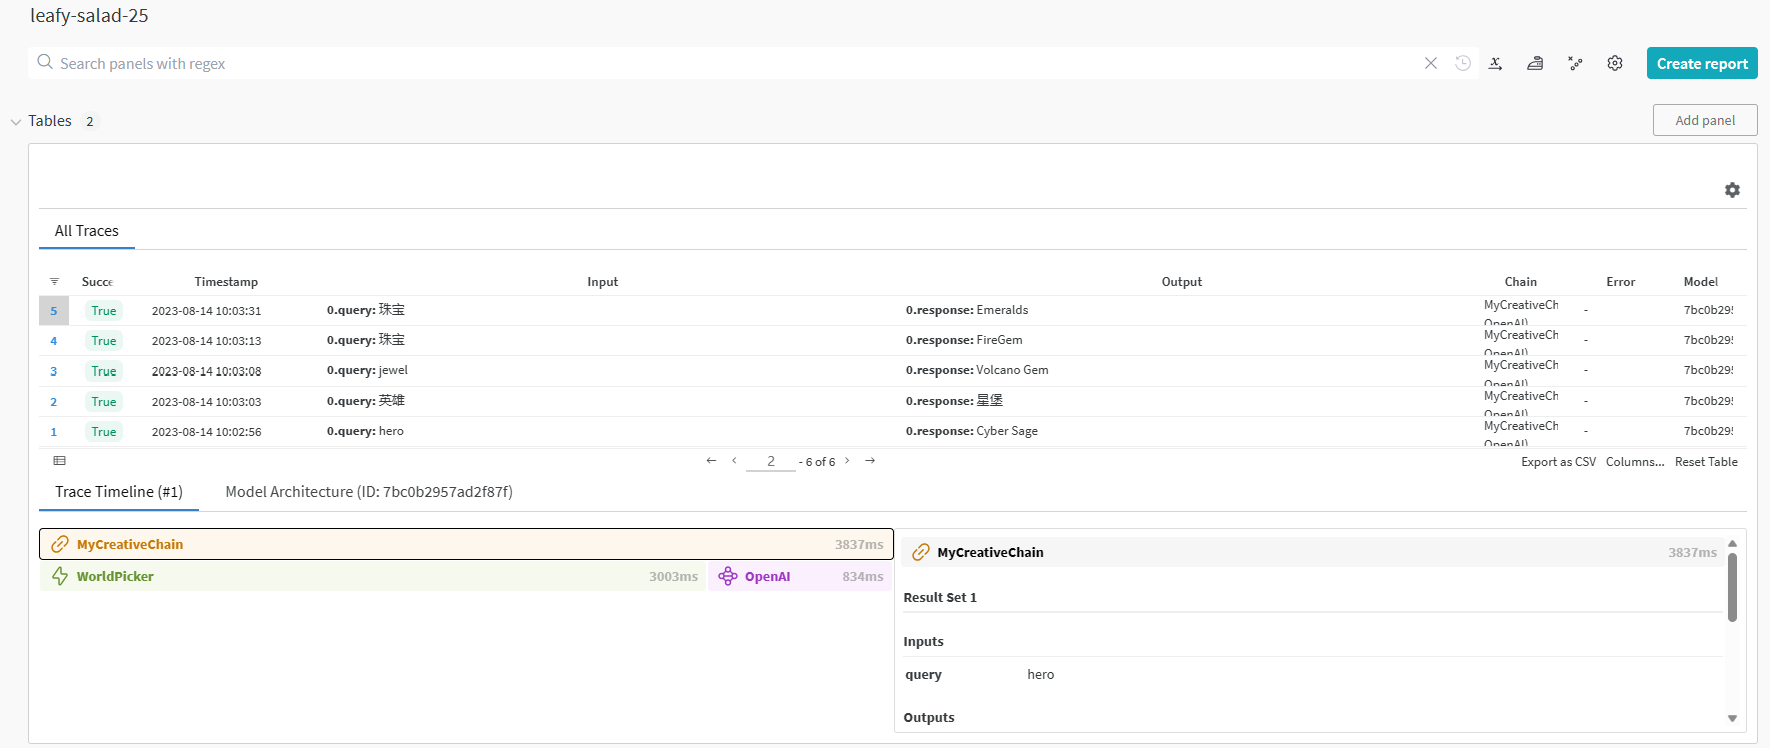

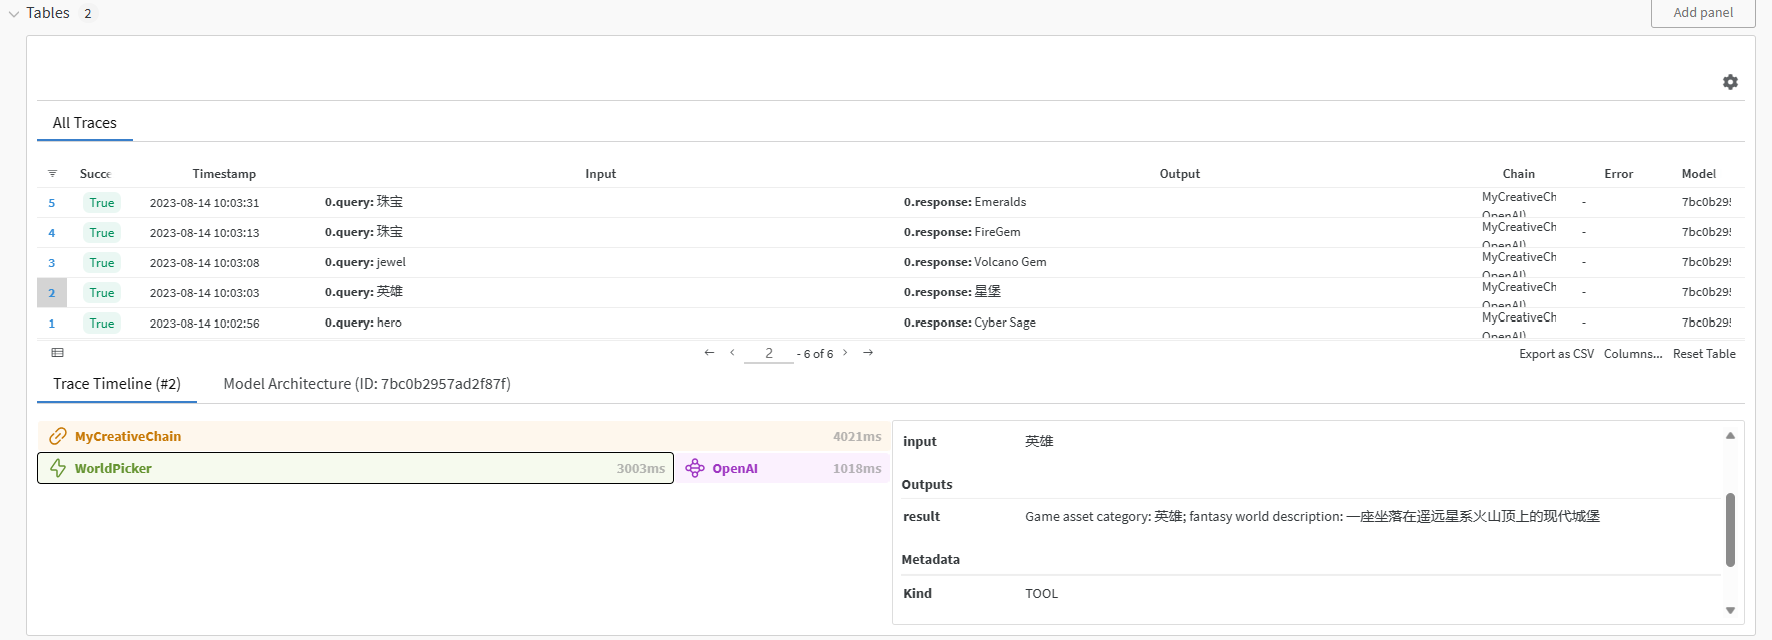

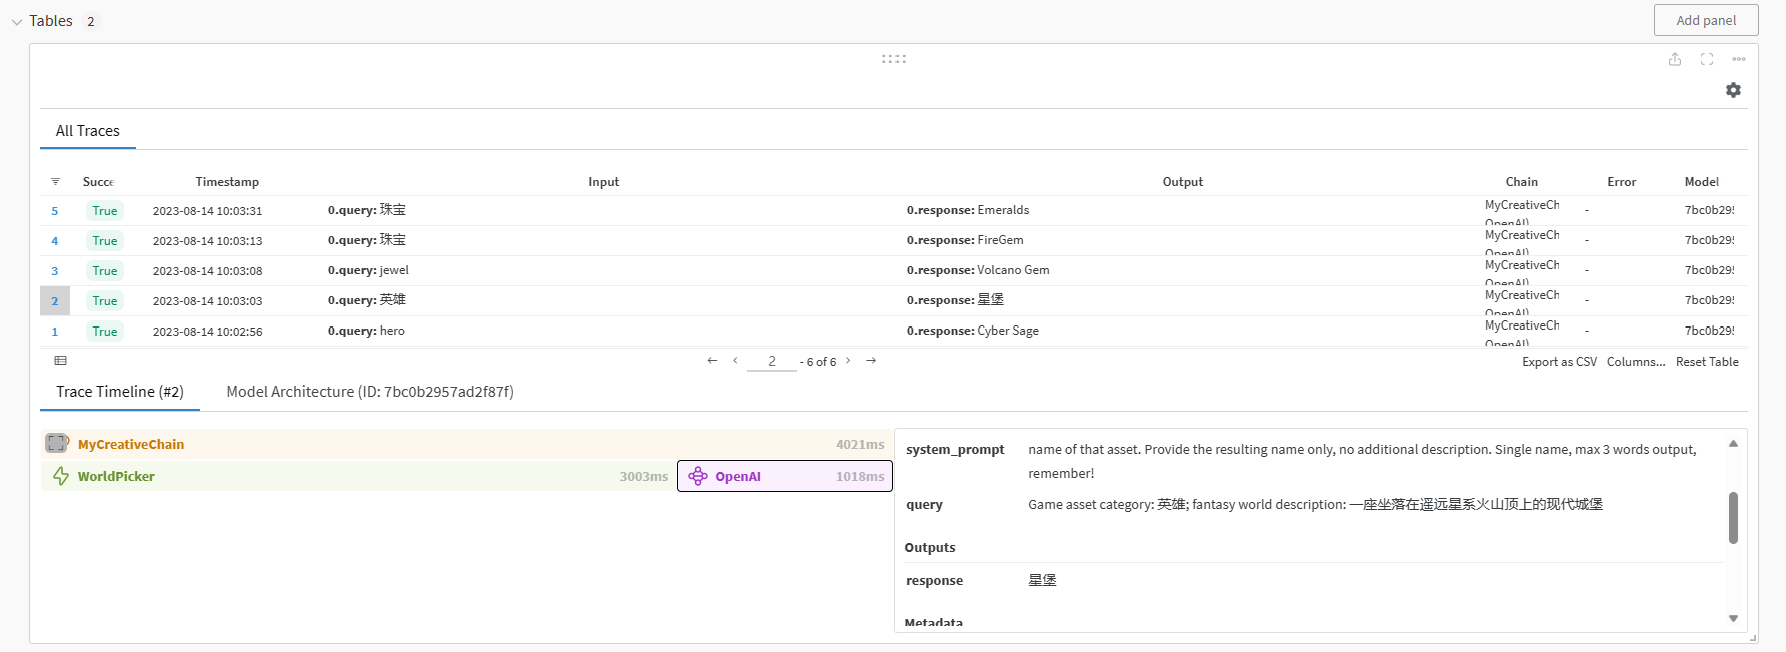

## 三、Langchain 代理

在第三个场景，我们会介绍一个能使用像 WorldPicker 和 NameValidator 工具来想出最终名字的代理。我们同样会在这里使用 LangChain 并且会阐述其 W&B 整合。

与每个步骤都是预先确定和固定的链相反，代理使用大语言模型推理并决定采取什么步骤或使用什么工具。在演示中，我们会看到代理更加不可预测。它不太确定，因此更难调试，所以使用追踪程序将会很有帮助。除了 WorldPicker 工具之外，这次我们将让代理使用一个新的工具 NameValidator 来检查名称是否合适。

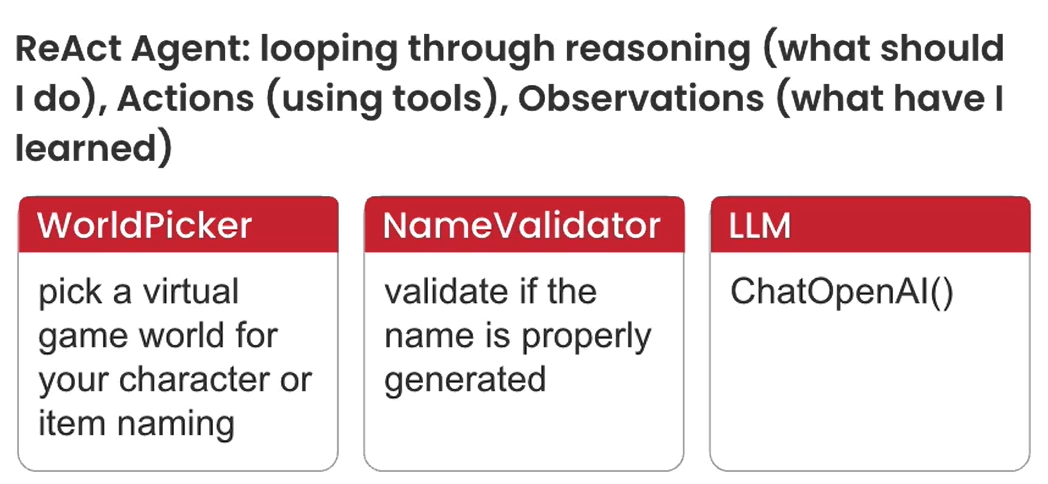

In [5]:
# 导入需要的库
from langchain.agents import AgentType, initialize_agent
from langchain.chat_models import ChatOpenAI
from langchain.tools import BaseTool

from typing import Optional

from langchain.callbacks.manager import (
    AsyncCallbackManagerForToolRun,
    CallbackManagerForToolRun,
)

In [6]:
# 初始化
wandb.init(project=PROJECT, job_type="generation")

In [7]:
# 这将设置跟踪，因此会自动记录这些跟踪
os.environ["LANGCHAIN_WANDB_TRACING"] = "true"

In [8]:
class WorldPickerTool(BaseTool):
    # 随机返回列表中的一种选择
    
    name = "pick_world"
    description = "pick a virtual game world for your character or item naming"
    worlds = [
                "a mystic medieval island inhabited by intelligent and funny frogs",
                "a modern anthill featuring a cyber-ant queen and her cyber-ant-workers",
                "a digital world inhabited by friendly machine learning engineers"
            ]

    def _run(
        self, query: str, run_manager: Optional[CallbackManagerForToolRun] = None
    ) -> str:
        """使用 tool"""
        time.sleep(1)
        return random.choice(self.worlds)

    async def _arun(
        self, query: str, run_manager: Optional[AsyncCallbackManagerForToolRun] = None
    ) -> str:
        """不同时使用 tool"""
        raise NotImplementedError("pick_world does not support async")
        
class NameValidatorTool(BaseTool):
    # 检查 query 或 name 是否少于20个字符
    
    name = "validate_name"
    description = "validate if the name is properly generated"

    def _run(
        self, query: str, run_manager: Optional[CallbackManagerForToolRun] = None
    ) -> str:
        """使用 tool"""
        time.sleep(1)
        if len(query) < 20:
            return f"This is a correct name: {query}"
        else:
            return f"This name is too long. It should be shorter than 20 characters."

    async def _arun(
        self, query: str, run_manager: Optional[AsyncCallbackManagerForToolRun] = None
    ) -> str:
        """不同时使用 tool"""
        raise NotImplementedError("validate_name does not support async")

In [9]:
class WorldPickerTool_cn(BaseTool):
    # 随机返回列表中的一种选择
    
    name = "pick_world"
    description = "为命名或角色选择一个虚拟的游戏世界"
    worlds = [
                "一个神秘的中世纪岛屿，居住着聪明有趣的青蛙",
                "一个现代蚁丘，有一个网络蚁女王和她的网络蚁工",
                "一个由友好的机器学习工程师居住的数字世界"
            ]

    def _run(
        self, query: str, run_manager: Optional[CallbackManagerForToolRun] = None
    ) -> str:
        """使用 tool"""
        time.sleep(1)
        return random.choice(self.worlds)

    async def _arun(
        self, query: str, run_manager: Optional[AsyncCallbackManagerForToolRun] = None
    ) -> str:
        """不同时使用 tool"""
        raise NotImplementedError("pick_world 不支持异步")
        
class NameValidatorTool_cn(BaseTool):
    # 检查 query 或 name 是否少于20个字符
    
    name = "validate_name"
    description = "验证名称是否正确生成"

    def _run(
        self, query: str, run_manager: Optional[CallbackManagerForToolRun] = None
    ) -> str:
        """使用 tool"""
        time.sleep(1)
        if len(query) < 20:
            return f"这是正确名字: {query}"
        else:
            return f"这个名字太长了，它应该少于20个字符"

    async def _arun(
        self, query: str, run_manager: Optional[AsyncCallbackManagerForToolRun] = None
    ) -> str:
        """不同时使用 tool"""
        raise NotImplementedError("validate_name 不支持异步")

In [10]:
# 实例化大模型
llm = ChatOpenAI(temperature=0.7, openai_api_key=openai.api_key)

In [11]:
# 生成可选择工具的list、生成代理
tools = [WorldPickerTool(), NameValidatorTool()]
agent = initialize_agent(
    tools, 
    llm, 
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    handle_parsing_errors=True,
    verbose=True
)

In [12]:
# 生成可选择的工具库变量、生成代理
tools_cn = [WorldPickerTool_cn(), NameValidatorTool_cn()]
agent_cn = initialize_agent(
    tools_cn, 
    llm, 
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    handle_parsing_errors=True,
    verbose=True
)

In [18]:
# 输入、运行
agent.run(
    "Find a virtual game world for me and imagine the name of a hero in that world"
)



> Entering new AgentExecutor chain...
I need to pick a virtual game world first and then think of a name for a hero in that world.
Action: pick_world
Action Input: None
Observation: a mystic medieval island inhabited by intelligent and funny frogs
Thought:I have picked a virtual game world, now I need to think of a name for a hero in that world.
Action: validate_name
Action Input: "Sir Ribbit"
Observation: This is a correct name: Sir Ribbit
Thought:I now know the final answer.
Final Answer: The virtual game world is a mystic medieval island inhabited by intelligent and funny frogs, and the hero's name is Sir Ribbit.

> Finished chain.


"The virtual game world is a mystic medieval island inhabited by intelligent and funny frogs, and the hero's name is Sir Ribbit."

In [19]:
# 输入、运行
agent_cn.run(
    "为我找一个虚拟的游戏世界，想象一下那个世界里英雄的名字"
)



> Entering new AgentExecutor chain...
我需要选择一个虚拟的游戏世界，并生成一个英雄的名字。首先，我需要通过调用pick_world来选择一个游戏世界。然后，我可以调用validate_name来验证生成的英雄名字是否正确。

Action: pick_world
Action Input: None
Observation: 一个现代蚁丘，有一个网络蚁女王和她的网络蚁工
Thought:我选择了一个现代蚁丘的游戏世界，现在我需要生成一个英雄的名字。

Action: validate_name
Action Input: "网络蚁女王"
Observation: 这是正确名字: 网络蚁女王
Thought:生成的英雄名字“网络蚁女王”是正确的。
Final Answer: 网络蚁女王

> Finished chain.


'网络蚁女王'

In [15]:
# 输入、运行
agent.run(
    "Find a virtual game world for me and imagine the name of a jewel in that world"
)



> Entering new AgentExecutor chain...
I need to pick a virtual game world first and then come up with a name for a jewel in that world.
Action: pick_world
Action Input: None
Observation: a digital world inhabited by friendly machine learning engineers
Thought:I have picked a virtual game world inhabited by friendly machine learning engineers. Now I need to come up with a name for a jewel in that world.
Action: validate_name
Action Input: "Sparkling Gem"
Observation: This is a correct name: Sparkling Gem
Thought:I now know the final answer
Final Answer: The name of the jewel in the virtual game world inhabited by friendly machine learning engineers is "Sparkling Gem".

> Finished chain.


'The name of the jewel in the virtual game world inhabited by friendly machine learning engineers is "Sparkling Gem".'

In [17]:
# 输入、运行
agent_cn.run(
    "为我找一个虚拟的游戏世界，想象一下那个世界里一颗宝石的名字"
)



> Entering new AgentExecutor chain...
我需要选择一个虚拟的游戏世界，并生成一颗宝石的名字。首先我需要使用pick_world工具来选择一个游戏世界，然后使用validate_name工具来验证生成的宝石名字是否正确。

Action: pick_world
Action Input: None
Observation: 一个现代蚁丘，有一个网络蚁女王和她的网络蚁工
Thought:我选择了一个现代蚁丘作为游戏世界。现在我需要使用validate_name工具来生成宝石的名字。

Action: validate_name
Action Input: "网络蚁宝石"
Observation: 这是正确名字: 网络蚁宝石
Thought:我现在知道了生成的宝石名字是"网络蚁宝石"。
Final Answer: "网络蚁宝石"

> Finished chain.


'"网络蚁宝石"'

In [20]:
# 输入、运行
agent.run(
    "Find a virtual game world for me and imagine the name of food in that world."
)



> Entering new AgentExecutor chain...
I need to pick a virtual game world and then come up with a name for a food item in that world.
Action: pick_world
Action Input: None
Observation: a mystic medieval island inhabited by intelligent and funny frogs
Thought:I have picked a virtual game world that is a mystic medieval island inhabited by intelligent and funny frogs.
Thought: Now I need to come up with a name for a food item in that world.
Action: validate_name
Action Input: "Froggy Delight"
Observation: This is a correct name: Froggy Delight
Thought:I now know the final answer.
Final Answer: The name of the food item in the virtual game world is "Froggy Delight".

> Finished chain.


'The name of the food item in the virtual game world is "Froggy Delight".'

In [21]:
# 输入、运行
agent_cn.run(
    "给我找一个虚拟的游戏世界，想象一下这个世界里食物的名字。"
)



> Entering new AgentExecutor chain...
我需要选择一个虚拟的游戏世界，并为其中的食物命名。我可以使用pick_world来选择游戏世界，然后使用validate_name来验证食物名称是否正确生成。
Action: pick_world
Action Input: None
Observation: 一个现代蚁丘，有一个网络蚁女王和她的网络蚁工
Thought:我选择了一个现代蚁丘作为游戏世界。现在我需要为其中的食物命名。
Action: validate_name
Action Input: "蚁糖"
Observation: 这是正确名字: 蚁糖
Thought:我现在知道了一个正确的食物名字
Final Answer: 蚁糖

> Finished chain.


'蚁糖'

In [22]:
wandb.finish()

打开上述结果第三行网址，查看结果！点击相应板块，你可以查看背后的相应过程！！！

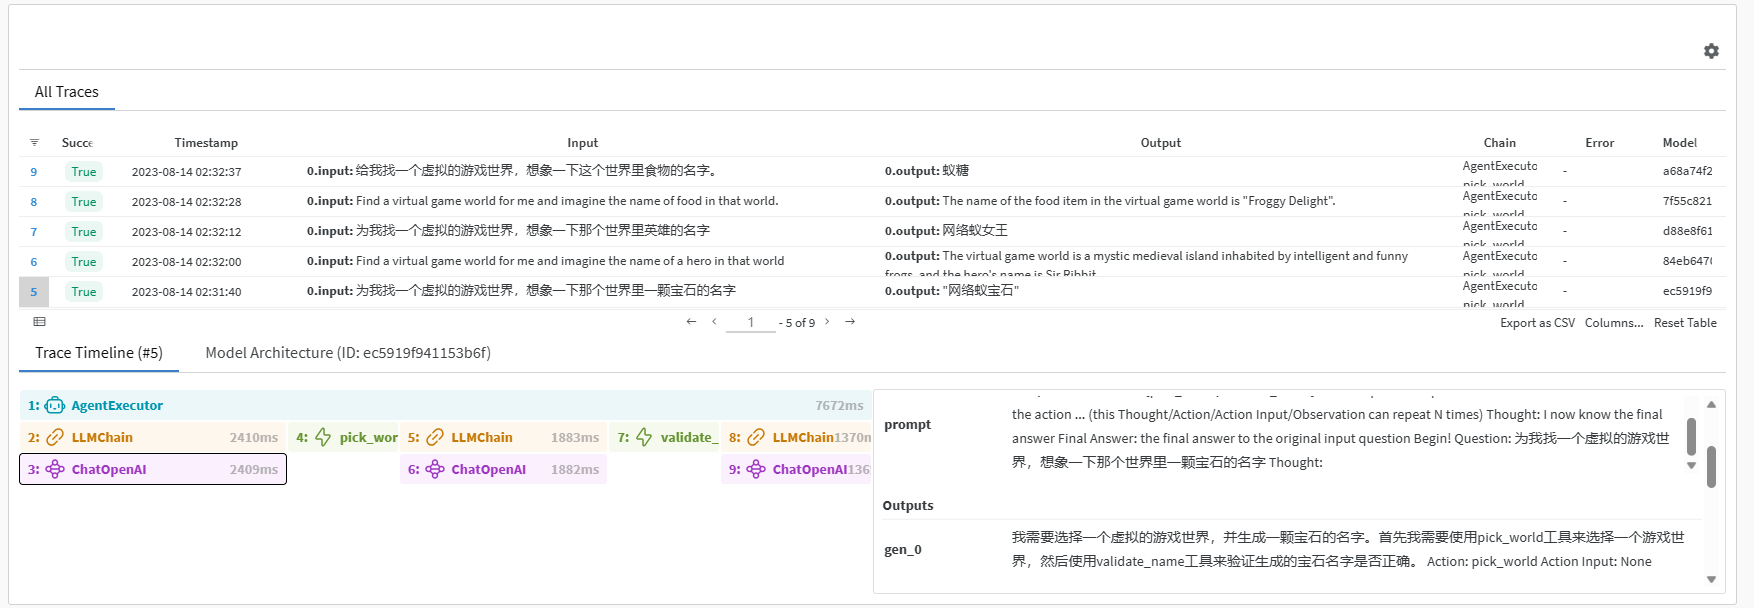

**注意**：大语言模型输出是可变的，所以结果可能每次不一致。